### General rules:
 * Replace *Template* by your *FirstnameLastname* in the filename.
 * For all figures that you generate, remember to add meaningful labels to the axes, and make a legend, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.

# AAND BCI - Exercise Sheet #02

#### Name: Sudeshna Bora

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

import bci_minitoolbox as bci

## Preparation: Loading Data

In [2]:
fname = 'erp_hexVPsag.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)

## Exercise 1: Plotting ERPs  (2 points)

Plot the average ERPs corresponding to *target* and *nontarget* stimuli in the time interval -100 to 1000 ms for the channels Cz and PO7.
In order to make the curves look reasonable, a so called 'baseline correction' should be performed: for each channel and trial, calculate the average across the prestimulus time interval -100 to 0 ms. This results in one value per channel and trial. Subtract this 'baseline' value from each (single channel/single trial) time course. 
The function `baseline` is provided in the `bci_minitoolbox`. It is recommended to have a look at the code.

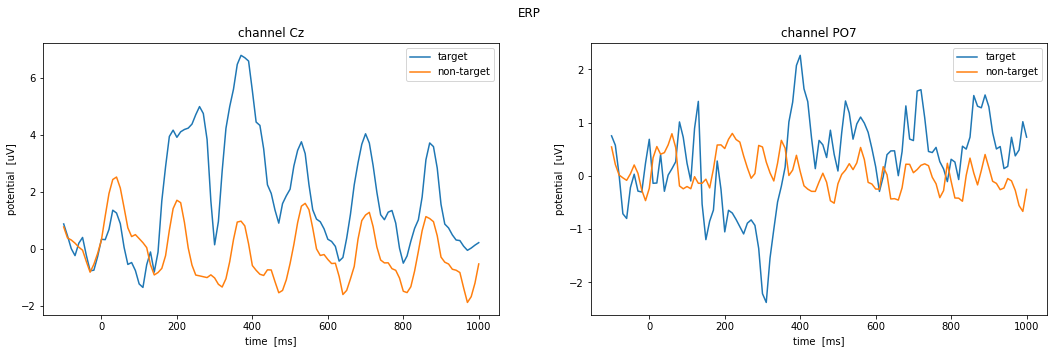

In [3]:
chans = ['Cz', 'PO7']
ival = [-100, 1000]
ref_ival = [-100, 0]

# made used of make epoch function to get the segments
epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, ival)

# Baseline correction:
epo = bci.baseline(epo, epo_t, ref_ival)

erp_target = np.mean(epo[:, :, mrk_class==0], axis=2)
erp_nontarget = np.mean(epo[:, :, mrk_class==1], axis=2)


plt.figure(figsize=[18, 5])
for i, chan in enumerate(chans):
    plt.subplot(1, len(chans), i+1)
    chidx = clab.index(chan)
    plt.plot(epo_t, erp_target[:, chidx], label=mrk_className[0])
    plt.plot(epo_t, erp_nontarget[:, chidx], label=mrk_className[1])
    plt.title('channel {}'.format(chan))
    plt.xlabel('time  [ms]')
    plt.ylabel('potential  [uV]')
    plt.legend()
plt.suptitle('ERP')
plt.show()

## Exercise 2: Scatter Plot of 2D Features  (3 points + 1 bonus)

Make a scatter plot of the two distributions - *targets* and *nontargets*, one dot for each trial. On the `x`-axis, plot the value of channel Cz at `t` = 380 ms, and at the `y`-axis the value of PO7 at `t` = 320 ms. Draw for both distributions the two principal axes, with the lengths of the axes being the standard deviation of the data in
that direction. 
**Bonus:** Draw also the corresponding ellipses. You can get that with a transformation of the unit circle.

(2, 1200)


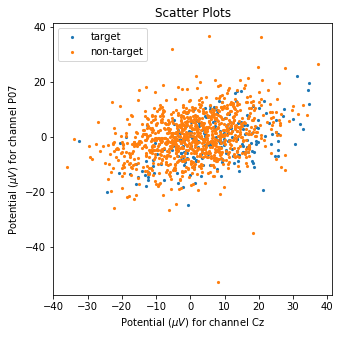

In [4]:
chans = ['Cz', 'PO7']
time_points = [380, 320]

epo, epo_t= bci.makeepochs(cnt, fs, mrk_pos, ival)
epo= bci.baseline(epo, epo_t, ref_ival)

# indices of the channels under concern
c0 = clab.index(chans[0])
c1 = clab.index(chans[1])

# maximum spread 
t0 = np.argmin(np.abs(epo_t - time_points[0]))
t1 = np.argmin(np.abs(epo_t - time_points[1]))

fv = epo[[t0, t1], [c0, c1], :]
print(fv.shape)
hf = plt.figure(figsize=(5,5))
for ci in range(len(mrk_className)):
    X = fv[:, mrk_class==ci ]
    plt.scatter(X[0, :], X[1, :], s=10, linewidths=0, label = mrk_className[ci])
plt.legend()
plt.xlabel(r'Potential ($\mu V$) for channel Cz')
plt.ylabel(r'Potential ($\mu V$) for channel P07')
plt.title('Scatter Plots')
plt.show()

## Exercise 3: Scalp Topographies of ERPs  (2 points)

Calculate the average potential separately for the classes *target* and *non-target* in the following time intervals [ms]: [160 200], [230 260], [300 320], and [380 430]. (This involves averaging over all trials of the respective class and averaging over all sample points in the respective time interval.)
Visualize the result as scalp topographies using the function `bci.scalpmap`, i.e., 4 maps for each class.
**Note:** In order to make the maps look reasonable, do a *baseline correction* as in the previous task. To make the maps comparable, use a common scale for the colorbar (see help of `scalpmap`). For ERPs, a range should be chosen for the colormap, which is symmetric around 0.

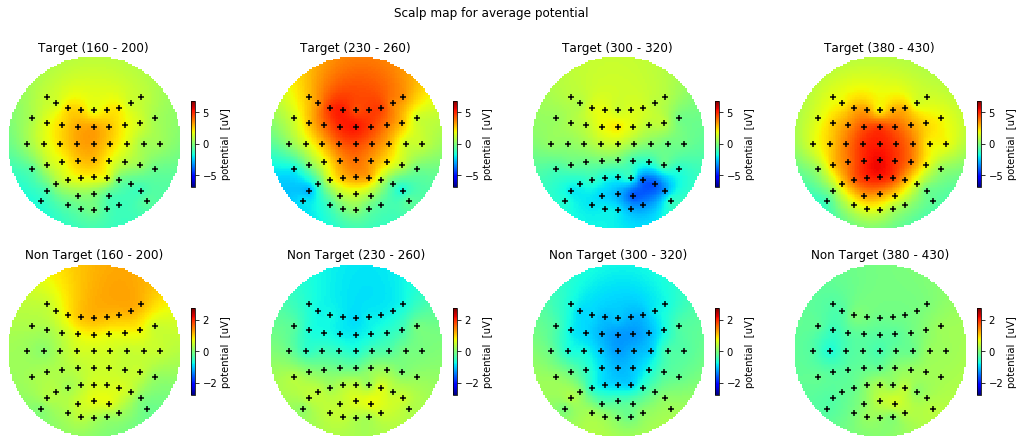

In [5]:
ival = [[160, 200], [230, 260], [300, 320], [380, 430]]

target_max = abs(erp_target).max()
nontarget_max = abs(erp_nontarget).max()

fig, axes = plt.subplots(2, 4, figsize=(18, 7))
plt.sca(axes[0, 0])
plt.ylabel('Target')
plt.sca(axes[1, 0])
plt.ylabel('Non Target')

for i in range(len(ival)):
    indices  = (ival[i][0] <= epo_t) & (epo_t <= ival[i][1])
    scalp_erp  = np.mean(epo[indices, :, :], axis=0)
    
    #for target
    plt.subplot(2, 4, i+1)
    erp_target = np.mean(scalp_erp[ :, mrk_class==0 ], axis=1 )
    bci.scalpmap(mnt, erp_target, clim=(-target_max,target_max), cb_label='potential  [uV]')
    plt.title('Target ({} - {})'.format(ival[i][0], ival[i][1]))
    
    # for non target
    plt.subplot(2, 4, i+5)
    erp_nontarget = np.mean(scalp_erp[ :, mrk_class==1 ], axis=1 )
    bci.scalpmap(mnt, erp_nontarget, clim=(-nontarget_max,nontarget_max), cb_label='potential  [uV]')
    plt.title('Non Target ({} - {})'.format(ival[i][0], ival[i][1]))

plt.suptitle('Scalp map for average potential')
plt.show()

## Exercise 4: Visualization with the Biserial Correlation Coefficient  (3 points)

Implement a function for the calculation of the signed `r^2`-value (see point-biserial correlation coefficient in BCI lecture \#02). From the given data set, extract epochs for the time interval [-100 600] ms relativ to each stimulus presentation.  Calculate for each channel and each point in time the signed `r^2`-value wrt. classes
*target* vs. *non-target* and visualize this (channel `x` time points) matrix (`pl.imshow`). Again, use 100 ms prestimulus for baseline correction.

In [6]:
def signed_r_square(epo, y):
    '''
    Synopsis:
        epo_r = signed_r_square(epo, y)
    Arguments:
        epo:    3D array of segmented signals (time x channels x epochs), 
                see makeepochs
        y:      labels with values 0 and 1 (1 x epochs)
    Output:
        epo_r:  2D array of signed r^2 values (time x channels)
    '''
    epo_target = epo[:, :, y==0]
    epo_nontarget = epo[:, :, y==1]
    n_target = epo_target.shape[2]
    n_nontarget = epo_nontarget.shape[2]
    scaling_factor = n_target*n_nontarget*1.0 / (n_target+n_nontarget)**2
    del_mu = epo_target.mean(axis=2) - epo_nontarget.mean(axis=2)
    return np.sign(del_mu) * scaling_factor * (del_mu)**2 / epo.var(axis=2)

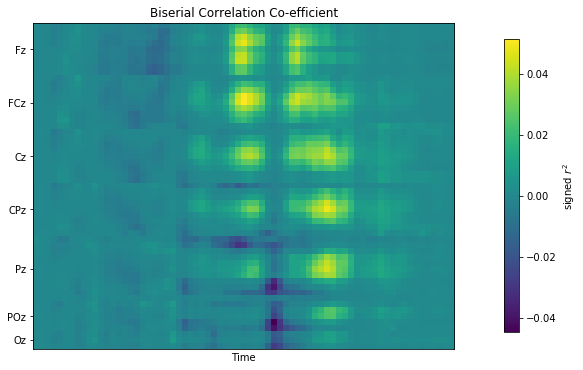

In [7]:
ival = [-100, 600]
ref_ival = [-100, 0]

epo_in, epoin_t = bci.makeepochs(cnt, fs, mrk_pos, ival)
epo_in = bci.baseline(epo_in, epoin_t, ref_ival)
signed_r2_value = signed_r_square(epo_in, mrk_class)

plt.figure(figsize=(18,6))
plt.imshow(signed_r2_value.T)
plt.colorbar(shrink=0.9, label=r'signed $r^2$')
plt.title('Biserial Correlation Co-efficient')
selected_channels = ['Fz','FCz','Cz','CPz','Pz','POz','Oz']
indices = [clab.index(x) for x in selected_channels]
plt.yticks(indices, selected_channels);
plt.xticks([])
plt.xlabel('Time')
plt.show()